# TP2 - Regression

Mục đích TP này : dự đoán một dải liên tục có dạng số (khác với TP1 là dự đoán dạng categorical (bệnh hay không bệnh))

In [18]:
# Check the directory now where i'm working
import os
print("Working directory:", os.getcwd())

Working directory: c:\Users\KTANG\Downloads\Python\Learn DS\TPs\TP2 - Regression


### ML Pipeline

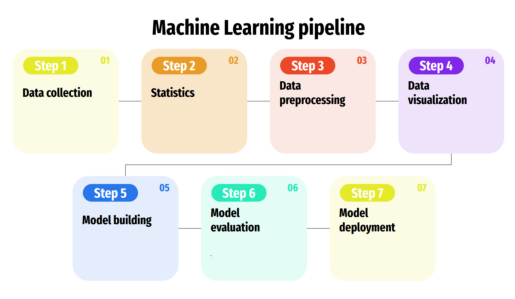

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(filename):
    img = mpimg.imread(filename)
    plt.imshow(img)
    plt.axis('off')  # Ẩn trục
    plt.show()

# Gọi hàm
show_image("../ML_Pipeline.png")

### B1 : Data collection : phải đi làm mới có (bỏ qua)
### Bước giữa B1 và B2 : Importing data

In [20]:
import pandas as pd

df = pd.read_csv("StudentScore.xls")
df #hoặc ghi "print(df)" hoặc df.info

# Ở đây có ba cột số là điểm toán, điểm văn, điểm viết và ta có thể chọn một trong ba cột này làm target
# hai cột còn lại sẽ tự động thành numerical feature
# Ở đây, ta chọn cột điểm toán làm target

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


### Có một cách để gộp B2+B4 vào một câu lệnh dựa vào thư viện "ydata-profiling" để có một report hoàn chỉnh về B2+B4

In [21]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="TP2 - Regression - Student Score Report")
# profile.to_file("TP2_Report.html")

#Xài xong thì comment nó lại để nó chạy một lần thôi là đủ rồi vì nó cũng chỉ cho ta coi dữ liệu lúc đầu chưa xử lý thôi

![image.png](Report_correlation.png)

Trong file report trên phần `Correlations` (hình trên), cần lưu ý rằng khi trong dataset có cả dữ liệu dạng numerical và cả dạng categorical thì chỉ quan tâm đến correlation giữa các cột giá trị dạng numerical thôi vì file report này sẽ tự động số hóa các giá trị categorical (số hóa theo kiểu theo thứ tự alphabet rồi đưa về dạng số) nên correlation của các cột giá trị dạng categorical không còn chính xác nữa.

Vậy các giá trị correlation của các cột categorical sẽ bỏ qua mà chỉ quan tâm correlation giữa các cột giá trị dạng numerical

In [22]:
# Vậy để dễ xem thì ta code thẳng để xem correlation giữa 3 cột numerical trong dataset

correlations = df.corr(numeric_only=True)
# correlations = df[["math score", "reading score", "writing score"]].corr()
print(correlations)

               math score  reading score  writing score
math score       1.000000       0.817580       0.802642
reading score    0.817580       1.000000       0.954598
writing score    0.802642       0.954598       1.000000


*Nhận xét 1 :* Nhìn vào các hệ số tương quan, ta thấy hai feature `reading score` và `writing` score có hệ số tương quan cao so với `target` => **CHỌN MÔ HÌNH TUYẾN TÍNH**
- Điểm mạnh của các mô hình tuyến tính :  đơn giản, nhỏ, nhẹ, chạy nhanh, có độ giải thích cao và phù hợp với các bộ dataset có hệ số tương quan cao giữa các features và target nếu cả target và feature đó đều là dạng numerical

*Nhận xét 2 :* Xét các features dạng numerical nhưng không có nghĩa là sẽ bỏ các features dạng categorical hay một feature bất kì đi
- Chỉ bỏ các feature đi khi biết chắc chắn rằng feature đó không ảnh hưởng gì đến mô hình đang xây dựng (dựa vào domain knowledge)

*Nhận xét 3 :* Khi đã biết trong một vài features có outliers (vd trong bài này có cột math score,...), khoan hẳn bỏ mà cứ xây dựng mô hình rồi sau đó loại bỏ outliers của features đó rồi chạy lại để xem performance của mô hình tăng như thế nào
- Vì trong thực tế, nhiều khi loại bỏ outliers có thể làm giảm performance của mô hình => đầu tiên cứ xây dựng mô hình cơ bản đã, sau đó áp dụng các kĩ thuật sau.
- Loại bỏ outliers (bước 2 trong 4 bước tiền xử lý dữ liệu) ko làm hoặc làm sau khi xây dựng mô hình cũng được, còn các bước còn lại tiền xử lý dữ liệu thì lúc nào cũng phải có

### Bước giữa bước B2+B4(Bước xem dữ liệu) và B3(Bước tiền xử lý dữ liệu):

Là bước chia dữ liệu theo :
- Phần A: theo chiều dọc (theo cột), tức là chia các cột X (các cột feature) với cột Y (cột target)
- Phần B: theo chiều ngang, tức là chia datasets thành 3 dataset con gồm bộ train, bộ validation và bộ test theo tỷ lệ tùy chọn (8-1-1, 9-0.5-0.5, 6-2-2)


Phần A

In [23]:
# Xác định target
target = "math score"

# dùng lệnh drop() trong pandas để xóa hàng (đưa chỉ số vào rồi thêm lệnh axis=0) 
# hoặc cột (đưa tên cột vào rồi thêm lệnh axis=1)
# Mục tiêu: Tách các cột X (các cột features) ra
x = df.drop(target, axis=1)

#Mục tiêu: Tách cột Y
y = df[target]

Phần B

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

x_train


,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
29,female,group D,master's degree,standard,none,70,75
535,female,group C,bachelor's degree,free/reduced,completed,83,83
695,female,group D,some college,free/reduced,none,89,86
557,male,group C,master's degree,free/reduced,none,67,66
836,male,group E,high school,standard,none,64,57
...,...,...,...,...,...,...,...
106,female,group D,master's degree,standard,none,100,100
270,male,group C,bachelor's degree,standard,none,63,61
860,female,group C,associate's degree,standard,none,62,53
435,male,group C,some college,free/reduced,completed,48,53


### Bước 3 : Tiền xử lý dữ liệu
![image.png](../Preprocessing_Pipeline.png)

#### B3.0 : Dùng fit(), transform(), fit_transform() để áp dụng thay đổi cho các thay đổi dữ liệu trong bước 3 tiền xử lý dữ liệu
Lưu ý trong các class lquan đến xử lý dữ liệu trong scikit learn (cả bước preprocessing hay modeling), có 3 thứ hay dùng là **fit()**, **transform()**, **fit_transform()**. Các hàm này được sử dụng cho nhiều mục đích, bao gồm việc chuyển đổi đặc trưng (feature transformation) hoặc xử lý dữ liệu (data preprocessing)

1.  *fit()* : Mục đích của hàm fit() là để tính toán các tham số cần thiết từ dữ liệu mà không thực hiện bất kỳ chuyển đổi nào trên dữ liệu đó. ***fit()*thường chỉ được thực hiện trên dữ liệu huấn luyện (training data)**
    *   Ví dụ :
        *   Đối với `StandardScaler`, hàm *fit()* sẽ tính toán giá trị trung bình (mean) và độ lệch chuẩn (standard deviation) của các đặc trưng trên tập dữ liệu đầu vào
        *   Đối với `MinMaxScaler`, hàm *fit()* sẽ tính toán giá trị nhỏ nhất (min) và giá trị lớn nhất (max) của các đặc trưng
        *   ví dụ khác khi đối với `SimpleImputer` (dùng để điền giá trị thiếu), hàm fit() sẽ tính toán giá trị trung bình (hoặc trung vị, mode) của cột để điền vào các giá trị thiếu

2.  *transform()* : dùng để áp dụng các thông số/các phép chuyển đổi đã được tính bởi hàm *fit()* vào các feature => Nó sẽ thay đổi định dạng của dữ liệu đầu vào
    *   **Được sử dụng cho dữ liệu huấn luyện (sau khi đã fit()) và dữ liệu kiểm tra (test data) hoặc dữ liệu mới** => Khi sử dụng cho bộ train, phải gọi fit trước để sử dụng transform còn khi sử dụng cho bộ test thì sử dụng trực tiếp transform() luôn chứ không được sử dụng fit()
    *   Ví dụ :
        *   Sau khi `StandardScaler` đã fit() và tính được mean và standard deviation, hàm transform() sẽ sử dụng các giá trị này để chuẩn hóa dữ liệu (trừ đi mean và chia cho standard deviation)
        *   Tương tự, `MinMaxScaler` sẽ sử dụng min và max đã fit() để chuẩn hóa dữ liệu về phạm vi từ 0 đến 1
    *   Điều cực kỳ quan trọng: Khi áp dụng cho dữ liệu kiểm tra hoặc dữ liệu mới, bạn chỉ sử dụng hàm transform() với cùng đối tượng "scaler" đã được fit() trên dữ liệu huấn luyện. Điều này đảm bảo rằng dữ liệu kiểm tra được chuyển đổi nhất quán với dữ liệu huấn luyện và ngăn chặn hiện tượng rò rỉ dữ liệu (data leakage) hoặc overfitting

3.  *fit_transform()* : một kết hợp của cả fit() và transform() mà sẽ vừa tính toán các tham số cần thiết, vừa áp dụng phép chuyển đổi dữ liệu ngay lập tức
    *   Hàm này thường được sử dụng trên dữ liệu huấn luyện để thực hiện cả hai bước một cách hiệu quả
    *   Ví dụ, khi bạn muốn chuẩn hóa dữ liệu huấn luyện bằng StandardScaler, bạn có thể gọi scaler.fit_transform(X_train) để vừa tính mean/std vừa áp dụng chuyển đổi
    
#### B3.1. Xử lý missing và invalid values

 - Nếu dữ liệu missing hay invalid dưới 5% (hoặc ngưỡng cho phép) thì `drop` luôn
 - Nếu không, thì hoặc dùng thẳng `MissForest` (điền tự động bằng 0 hoặc mean mà không thay đổi distribution) hoặc cách bình thường rằng thay thế bằng mean hoặc median (dùng hàm `SimpleImputer` trong sklearn) 
    *   Khi mới học, ta làm `SimpleImputer` để hiểu

In [51]:
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(strategy="median") #dùng thay bằng median để đỡ bị (gần như không bị) ảnh hưởng bởi outliers hơn

# x_train[["reading score", "writing score"]] = imputer.fit_transform(x_train[["reading score", "writing score"]])

# Lưu ý rằng, với bộ datasets hiện tại vì các dòng này không có ý nghĩa gì cả vì bộ dataset này cleaned (ko có missing hay invalid values)
# Nhưng để có một script tổng quát có thể dùng lại thì ta cứ để bước này vào

#### B3.3 : Data scaling 

Lý thuyết cụ thể coi phần này TP1 - Classification

Tóm tắt ngắn gọn:

* **Dùng `MinMaxScaler`** khi:

  * Dữ liệu **phân bố không chuẩn** (còn gọi là không phải PP chuẩn (PP Gaussian))
  * Muốn đưa dữ liệu về **\[0, 1]**
  * Đặc biệt phù hợp cho **mô hình nhạy với scale** như *KNN*, *SVM*, *Neural Networks*

* **Dùng `StandardScaler`** khi:

  * Dữ liệu có **phân phối chuẩn** (xấp xỉ Gaussian)
  * Muốn giữ lại **thông tin về phân phối gốc** (mean = 0, std = 1)
  * Thường dùng cho **hầu hết thuật toán tuyến tính** như *Logistic Regression*, *Linear Regression*, *PCA*

**Mẹo**: Nếu không chắc, bắt đầu với `StandardScaler`, nhưng dùng `MinMaxScaler` cho các mô hình nhạy cảm với khoảng cách.


In [26]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# x_train[["reading score", "writing score"]] = scaler.fit_transform(x_train[["reading score", "writing score"]])
# x_train[["reading score", "writing score"]]

#### Nhận xét 


Giả sử sau 2 bước trên mà còn các bước tiền ửu lý dữ liệu khác thì cũng làm y như vậy, cad ta sẽ gọi mô hình đó ra rồi lại `fit_transform()` với bộ train rồi `transform()`với bộ test. Đại ý thì cách chúng ta xử lý nó đang giống hình bên dưới

![image.png](pipeline_preprocessing_not_optimized.png)

1. *Giải thích :* Giả sử ta có bộ dataset tượng trưng cho ô màu đỏ và có vài bước tiền xử lý dữ liệu (`Imputer`, `Scaler`, `...`). Quá trình sẽ là :
    - đầu tiên dữ liệu được truyền vào bước 1 của chúng ta sau đó ta hứng kết quả đầu ra (biểu tượng ở dưới cùng kia). 
    - sau đó lấy kết quả vừa hứng được từ bước 1 để truyền vào bước 2 để xử lý trước khi đẩy xử liệu ra để sử dụng dữ liệu đầu ra đó truyền vào bước sau.

    => Cad ta liên tục đổ dữ liệu vào một bước rồi hứng output ra của nó để đổ vào bước sau đó và cứ liên tục fit input vào lấy output ra như vậy đến hết

    => Cách làm thủ công như này làm cho script bị dài và các bước con nhìn sẽ bị rời rạc với nhau dẫn đến khó optimize scripts về sau vì khi nó là một cụm hoàn chỉnh thì optimize nó dễ chứ nếu chỉ mỗi bước 3 (Preprocessing) mà có 5-6 cụm khác nhau thì rất khó vì chả biết phải tối ưu ông nào trong 5-6 cụm kia (tối ưu cụm này chưa chắc đã tối ưu ông kia mà tối ưu một lúc 5-6 thì mất tgian và tài nguyên) 

    **=> Tôi comment các bước trên lại để suy nghĩ và tạo ra ý tưởng làm nhanh hơn**

2. *Suy ra ý tưởng :* Tôi muốn gom các bước con của bước preprocessing này lại một khối (`một pipeline`) như hình
    - Ta gom các bước con của bước preprocessing này lại thành một đường ống để khi ta thả dữ liệu vào bước con đầu tiên thì bước con đầu tiên này sẽ tự động tạo ra output để nhét vào bước con thứ hai, bước con thứ hai xử lý ra output nhét vào bước con thứ ba,... đến khi bước con cuối cùng ra được output và ta chỉ hứng/nhận lấy output cuối cùng của cả pipeline này thôi. 

![image.png](pipeline_preprocessing_optimized.png)



3. *Giải pháp cho pipeline preprocessing* : trong sklearn, ta có một hàm tên `Pipeline` của thư viện `sklearn.pipeline` là một chuỗi biến đổi dữ liệu với khả năng có thể dự đoán mô hình luôn (optinal). Ý tưởng là hàm `Pipeline` này sẽ gom tất cả các bước ta muốn biến đổi dữ liệu lại và chỉ fit_transform một lần thôi.

    => **PP này sẽ gộp tất cả các bước preprocessing thành một đoạn code chứ không chia nhỏ ra các bước B3.1, B3.2,... nữa nhưng bên trong vẫn sẽ tuân thử theo 5 bước con của tiền xử lý dữ liệu**

4. *HDSD cơ bản hàm `Pipeline` :* ta có parameter
    *   `steps` :  một list of tuples, piple preprocessing của ta có bao nhiều bước thì cái list of tuples này sẽ có bấy nhiêu phần tử. Mỗi tuples sẽ bao gồm 2 thành phần gồm `tên` và `phép biến đổi tương ứng` (StandardScaler(), SimpleImputer(), SVC(),.... Đặt tên dễ hiểu sao cho nhìn là biết ta đang muốn xài phép biến đổi nào vì ta sẽ dùng đến các `tên` sau đó khi sử dụng `GridSearchCV`

#### B3.bis.1 : Biến đổi theo kiểu mới (dùng Pipeline) cho các feature dạng NUMERICAL

![image.png](Pre_processing_num_features.png)


In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_transfomer = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

# Đã cbi xong pipelien preprocessing, bây giờ fit_transform
processed_num_data = num_transfomer.fit_transform(x_train[["reading score", "writing score"]])

# Kiểm tra giá trị trước vào sau khi tiền xử lý dữ liệu
# for i, j  in zip(x_train[["reading score", "writing score"]].values, processed_data):
#     print(f'not processed data is {i}, processed data is {j}')

# Bây giờ tôi chỉ muốn kiểm tra 10 giá trị đầu tiên trước vào sau khi tiền xử lý dữ liệu :
for idx, (i, j) in enumerate(zip(x_train[["reading score", "writing score"]].values, processed_num_data)):
    if idx >= 5:
        break
    print(f'{idx}, not processed data is {i}, processed data is {j}')

0, not processed data is [70 75], processed data is [0.03079054 0.43405338]
1, not processed data is [83 83], processed data is [0.9302895  0.96470125]
2, not processed data is [89 86], processed data is [1.34544287 1.1636942 ]
3, not processed data is [67 66], processed data is [-0.17678614 -0.16292548]
4, not processed data is [64 57], processed data is [-0.38436283 -0.75990434]


#### B3.bis.2 : Biến đổi theo kiểu mới (dùng Pipeline) cho các feature dạng CATEGORICAL ORDINAL
![image.png](Pre_processing_ordinal_features.png)


ở đây là cột `parental level of education`

Ý tưởng để biến đổi kiểu categorical ordinal là ta phải mã hóa các giá trị trong feature đó từ 0 đến k-1 với k là số giá trị distinct của feature đó

In [40]:
# Các giá trị duy nhất của cột parental level of education là :
print(df["parental level of education"].unique())

["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']


Ở đây ta chọn thứ tự như sau :

0. some high school
1. high school
2. some college
3. bachelor's degree
4. associate's degree
5. master's degree

Bây giờ ta sử dụng hàm `OrdinalEncoder` trong thư viện `sklearn.preprocessing` để mã hóa các feature dạng categorical ordinal. Ở đây ta có parameter quan trọng nhất của hàm này là `categories`
- nếu để mặc định là 'auto' thì nó sẽ xếp theo thứ tự chữ cái alphabet thì trong TH này sẽ sai
- nếu không, để ở dạng array-like, tức là dạng list của list `[[]]`, tức là vì hàm `OrdinalEncoder` có thể làm cùng lúc nhiều features, nên ví dụ khi làm cùng lúc 3 phần tử thì ta sẽ tuyền vào parameter dạng `[[], [], []]`. Ở đây, mỗi một list con sẽ là một danh sách các giá trị theo thứ tự của từng cột một

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# List thứ tự các giá trị của cột "parental level of education" nhằm để bỏ vào parameter "categories" của hàm "OrdinalEncoder"
order_feature = ['some high school', 'high school', 'some college', "bachelor's degree", "associate's degree", "master's degree"]

ordinal_transfomer = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), 
                               ("ord_encoder", OrdinalEncoder(categories= [order_feature]))])

processed_ordinal_data = ordinal_transfomer.fit_transform(x_train[["parental level of education"]])

# Kiểm tra 10 giá trị đầu tiên trước vào sau khi tiền xử lý dữ liệu
for idx, (i, j)  in enumerate(zip(x_train[["parental level of education"]].values, processed_ordinal_data)):
    if idx < 10:
        print(f'{idx}, not processed data is {i}, processed data is {j}')


0, not processed data is ["master's degree"], processed data is [5.]
1, not processed data is ["bachelor's degree"], processed data is [3.]
2, not processed data is ['some college'], processed data is [2.]
3, not processed data is ["master's degree"], processed data is [5.]
4, not processed data is ['high school'], processed data is [1.]
5, not processed data is ['high school'], processed data is [1.]
6, not processed data is ["bachelor's degree"], processed data is [3.]
7, not processed data is ["associate's degree"], processed data is [4.]
8, not processed data is ['high school'], processed data is [1.]
9, not processed data is ['some high school'], processed data is [0.]


#### B3.bis.3 : Biến đổi theo kiểu mới (dùng Pipeline) cho các feature dạng CATEGORICAL NOMINAL
![image.png](Pre_processing_nominal_features.png)


ở đây là cột `race/ethnicity`

Ý tưởng cơ bản là sẽ sử dụng OnehotEncoder, nhưng sẽ ra sao nếu ta sử dụng hàm OrdinalEncoder?